# Lab 3: Asking a Statistical Question

## William Olsen, partners with Jennifer Vo

Within this report we will be focusing on how to ask a statistical question.  Asking and answering a statistical question is generally requires the following three steps:

1) Writing down in words _precisely_ what question we are trying to ask.
2) Translating the precise english into a mathematical expression.  Often containing the PDF of the background - determining of which can be considered a substep of this step.  Then evaltating the integral.
3) Converting the probability from the previous step into a sigma.

In this lab we will presume that we know the background distribution and will focus on asking the statistical question and getting the correct results in a clear manor.

In [1]:
# general imports
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats

# plotting setup
plt.rcParams["figure.figsize"] = (20,15)

## Problem 1

Lets presume that we are performing an experiment which requires precise temperature control to work reliably.  Specifically, we would like our temperature to be 12 Kelvin.  Our data shows that the temperature stays around a mean value of 12 Kevlin but has a standard deviation of 0.4 degrees which is the result of the thermal control systems.

At some points our system misbehaves and we see situations where the temperature is not near 12 K, additionally the therometry has varius glitches wich results in very high or low readings that do not correspond to the true temperature.  While sometimes the outliner values are true readings they generally are not so we would like to look at how we can eliminate these outliers.

Let's begin by simulating some data for our hypothetical situation.  Lets generate some good data from a Gaussian distribution and then add some outlier readings:

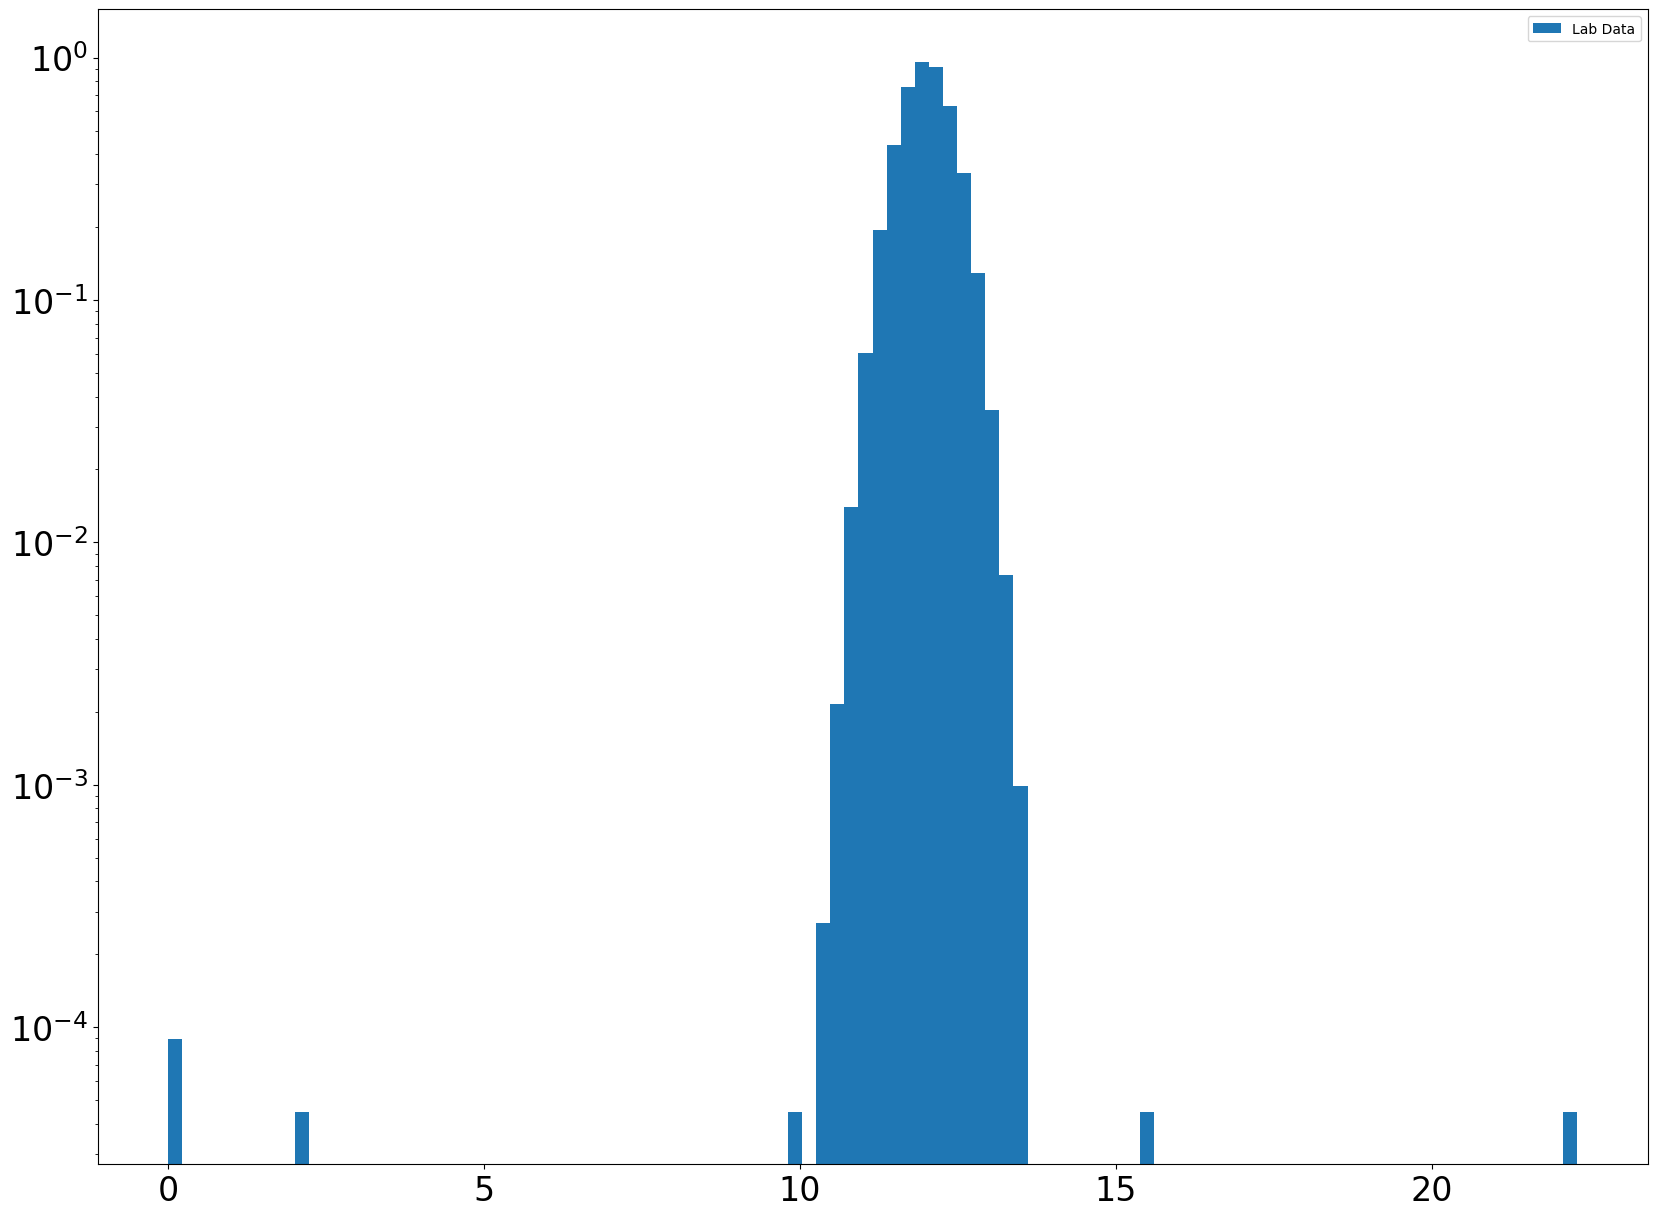

In [11]:
# distirbution information
mean_temp = 12
std_temp = 0.4

# generation of good points and bad points
true_data_N = 100000
outliers = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
draw = np.append(stats.norm.rvs(loc=mean_temp, scale=std_temp, size=true_data_N), outliers)

# plotting
fig, ax = plt.subplots(1, 1)
ax.hist(draw, 100, density=True, label="Lab Data")
plt.tick_params(labelsize = 24)
plt.yscale('log')
plt.legend()
plt.show()

### Part A

As previously stated, our goal is to identify and remove bad data.

Lets begin by first exploring our data when it is viewed on a non-logarithmic scale:

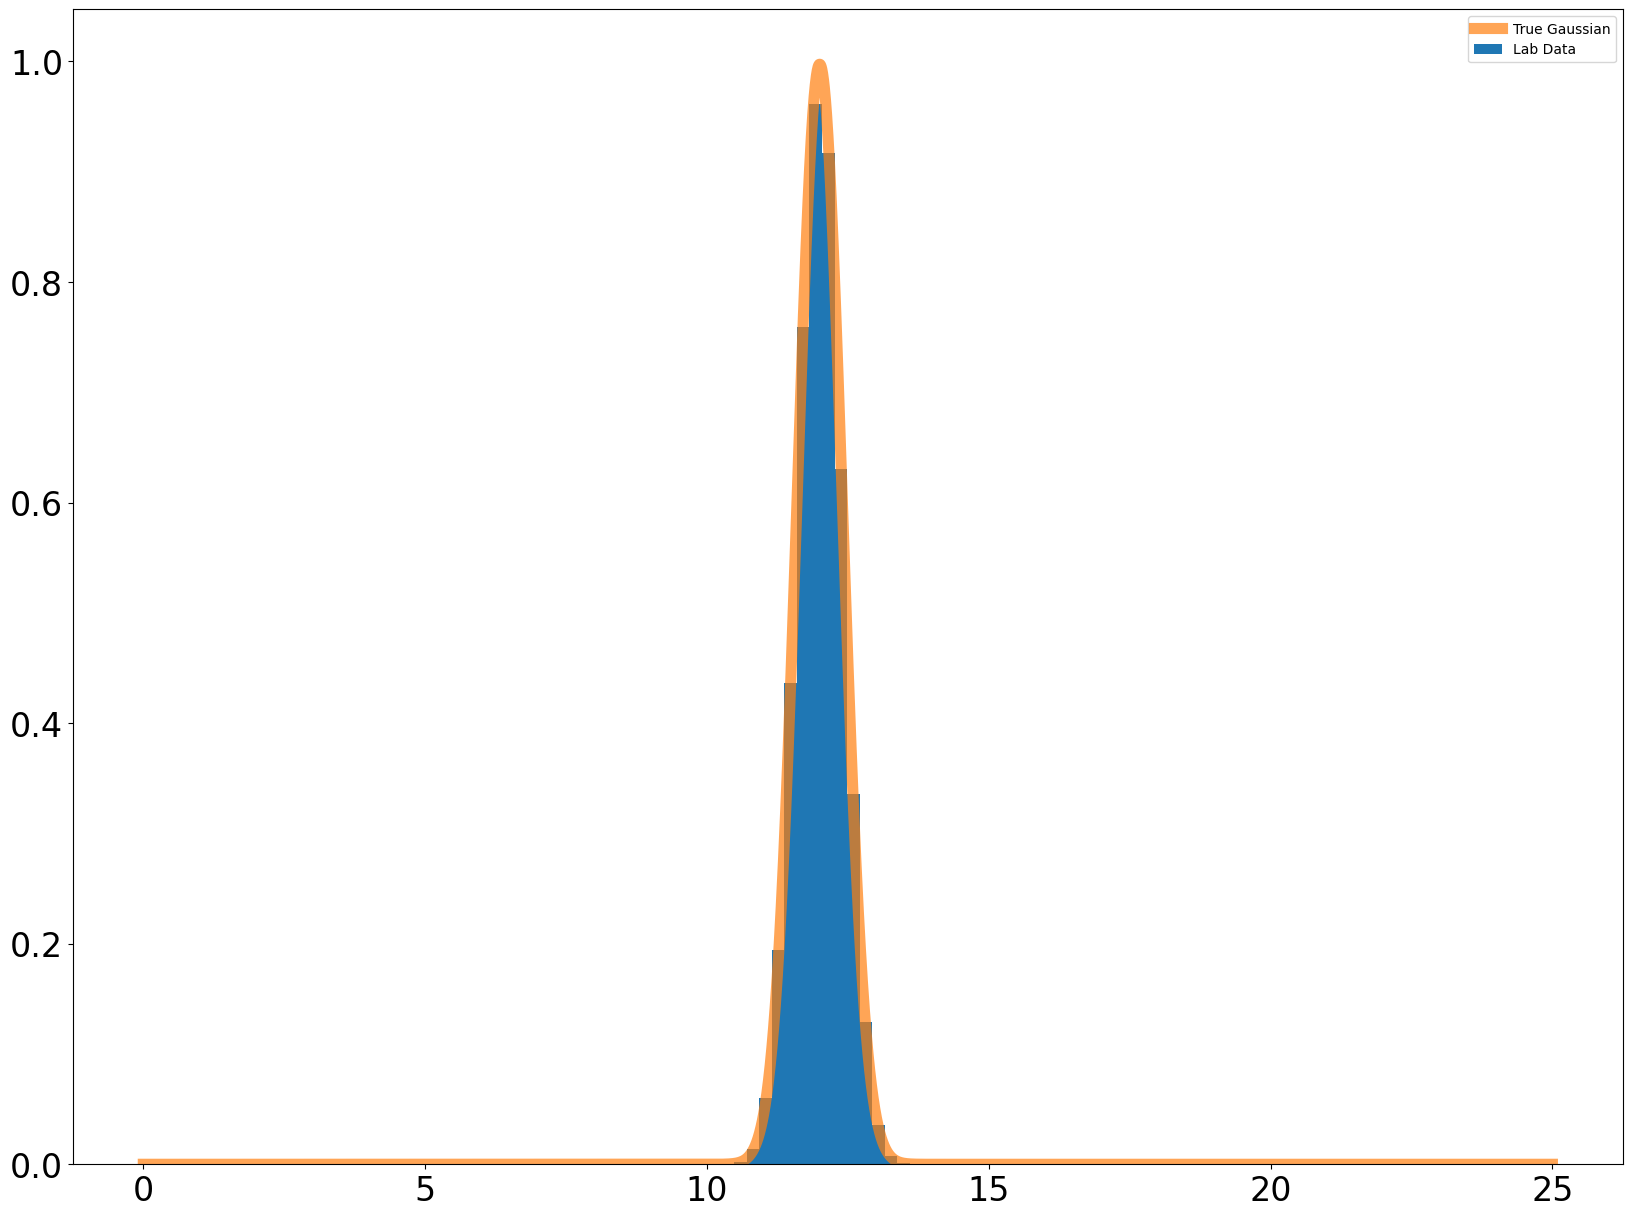

In [12]:
xs_true_gaus = np.linspace(0, 25, 5000)
probs_true_gaus = stats.norm.pdf(xs_true_gaus, loc=mean_temp, scale=std_temp)

fig, ax = plt.subplots(1, 1)
ax.hist(draw, 100, density=True, label="Lab Data")
ax.plot(xs_true_gaus, probs_true_gaus, linewidth=8, alpha=0.7, label="True Gaussian")
plt.tick_params(labelsize = 24)
plt.legend()
plt.show()

From the above graph we see that when we view our distribution on a non-logarithmic plot the outliers are no longer visable because they are inconsequential compared to the rest of the data.  This reinforces the benfits of always looking at our plots on a semi-log scale.  Now lets go back to the semi-log plot and look at out true distribution and it's comparison to our data points:

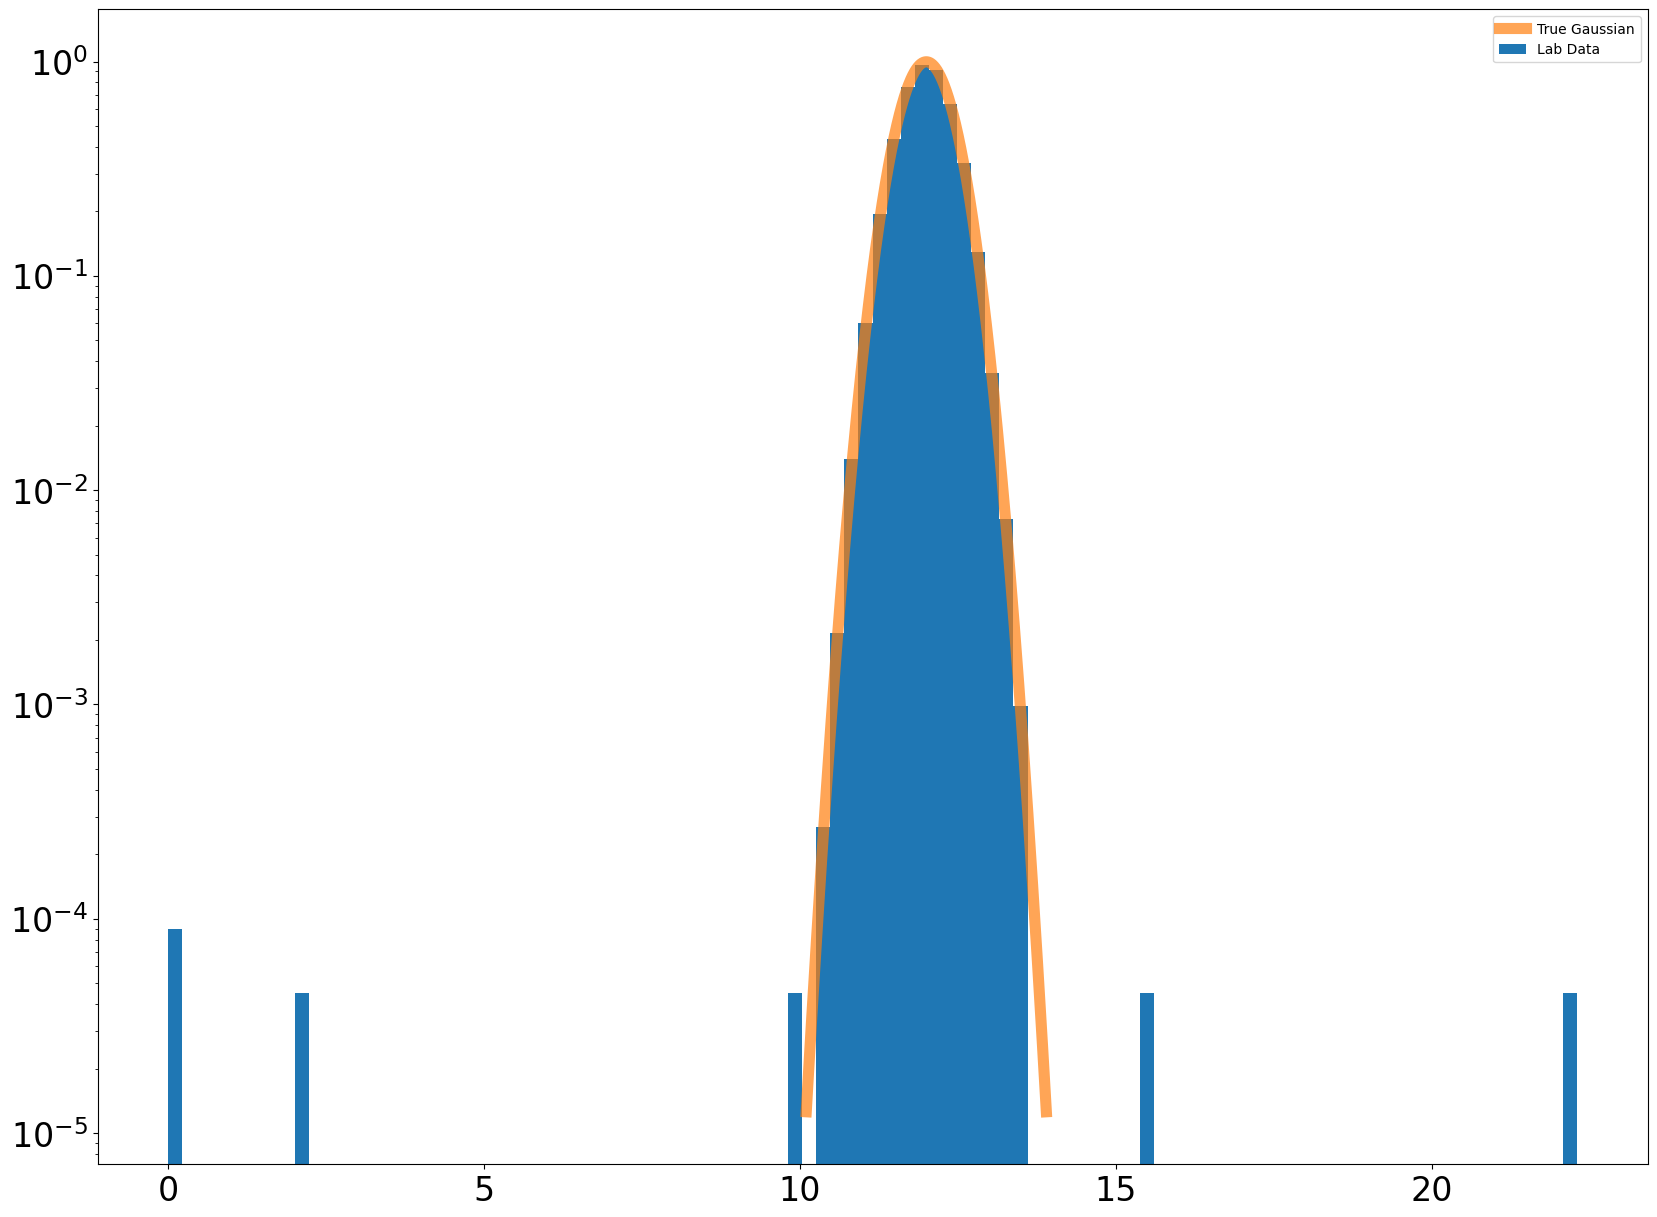

In [13]:
xs_true_gaus_truncated = np.linspace(10.1, 13.9, 1000)
probs_true_gaus_truncated = stats.norm.pdf(xs_true_gaus_truncated, loc=mean_temp, scale=std_temp)

fig, ax = plt.subplots(1, 1)
ax.hist(draw, 100, density=True, label="Lab Data")
ax.plot(xs_true_gaus_truncated, probs_true_gaus_truncated, linewidth=8, alpha=0.7, label="True Gaussian")
plt.tick_params(labelsize = 24)
plt.yscale('log')
plt.legend()
plt.show()

From the above plot we see that the outliers are unrelated to the true Gaussian distribution entirely.  We also see from the plot on a non-logarithmic scale that the Gaussian rare events begin when the temperature is less than about 10 Kelvin or larger than around 14 Kelvin.  Thus we can view these outliers as rare events when we have this Gaussian distribution - the event for which our background would produce one of these outliers has a very small probability.

Now that we have explored our data, lets propose a statistical question for removing the outliers in our data:

> When the probability that an outlier candidate was produced by the background Gaussian distribution ($\mu=12$, $\sigma=0.4$) is $\pm 5\sigma$ or more (i.e., values between $-\infty\sigma$ and $5\sigma$ or between $5\sigma$ and $\infty\sigma$) than we will identify that candidate as a outlier and will discard it from the data set.

The reason I choose the above question is for the following reasons: first we know that we would like to remove the outliers so the goal of the question is to address how we can identify an outlier.  I have choose to identify an outlier as an event that has a probability equal to or smaller than the probability associated with a $5\sigma$ event.  This bound will ensure that only rare events for the distribution are considered outliers and we know, based on the shape of the distribution from the above graphs, that the outliers, visually, correspond to rare events.

Transforming this calculation into math, we will find all data points that have an $x$ value which is greater than or equal to $12 + T_{threshold}$ Kevlin or less than or equal to $12 - T_{threshold}$ Kelvin where $T_{threshold}$ is calculated using the following equation:

$$\int_5^\infty \text{pdf}_{normal}(x) dx = \int_{12 + T_{threshold}}^\infty \text{pdf}_{temperature \text{ } distribution}(x) dx$$

$$\int_5^\infty \frac{1}{\sqrt{2\pi}} e^{-x^2 / 2} dx = \int_{12 + T_{threshold}}^\infty \frac{1}{0.4 * \sqrt{2\pi}} e^{-(x-12)^2/(2*0.4^2)} dx$$

$$\int_5^\infty e^{-x^2 / 2} dx = \int_{12 + T_{threshold}}^\infty \frac{1}{0.4} e^{-(x-12)^2/(0.32)} dx$$

Let's now perform the reverse integral (specifically the inverse survival function) to determine the value of $T_{threshold}$:

In [14]:
# define the sigma value
sigma = 5

# determine the probability associated with this sigma
prob_sigma = stats.norm.sf(sigma, loc=0, scale=1)

# use the inverse survival function to determine the value that has the same associated probability
T_same_prob = stats.norm.isf(prob_sigma, loc=mean_temp, scale=std_temp)

# compute T_threshold
T_threshold = T_same_prob - mean_temp

print(f'The value of T_threshold is {T_threshold}')

The value of T_threshold is 2.0


Now we know that for a data point to be considered an outlier based on the requirements previously outlined, that data point must have a temperature equal to or less than 10 Kelvin or greater than or equal to 14 Kelvin.  Lets now calculate how many values fit this metric:

In [15]:
# print information we already know about the true outlier and true data counts
print(f'In total we have {len(draw)} temperatures we would like to identify.')
print(f'The number of true temperature data points is: {true_data_N}')
print(f'The number of true outliers is: {len(outliers)}')

# now calculate how many outliers are identified
def is_outlier(value):
    return value <= mean_temp - T_threshold or mean_temp + T_threshold <= value

N_identified_outliers = 0
for d in draw:
    if (is_outlier(d)):
        N_identified_outliers += 1
        
print(f'The number of identified outliers based on our metric is: {N_identified_outliers}')
print(f'The number of identified data points based on our metric is: {len(draw) - N_identified_outliers}')

In total we have 100008 temperatures we would like to identify.
The number of true temperature data points is: 100000
The number of true outliers is: 8
The number of identified outliers based on our metric is: 6
The number of identified data points based on our metric is: 100002


Based on the above results, lets construct a truth table that captures the accuracy of our previously defined performance metric to determine if data should be considered an outlier or not:

|          | **True T**     | **Bad T** |
|--------------|-----------|------------|
| Identified as Good T | 100000      | 2        |
| Identified as Bad T      | 0  | 6       |

### Part B

In the above table we see that all of our real temperature data points were identified as such however two of our false readings were identified as true readings.  We see that the proposed metric is does a fairly good job of seperating the true and false readings.  The number of omissions of true data is directly related to the initial threshold parameter that we set.  In our proposed method, we set that threshold at $5\sigma$.  As this value is decreased, we will ommit more and more of the true data but will be more certain that we are not including any false readings.  The percentage of true temperature readings that would be ommited is a predictable value because our data is from a Gaussian.  We know that on a Gaussian, 68% of the readings, on average, will lie between $-1\sigma$ and $1\sigma$.  Thus we would ommit, on average, 32% of our true temperature readings.

If instead we had set our value at $2\sigma$ we know that 95% of our readings, on average, will lie between $-2\sigma$ and $2\sigma$ thus we will ommit 5% of the true temperatue readings.  Similarly, if we set our value to $3\sigma$ we would ommit 0.3% of our true temperature readings.  Even at this point of 3% we see that the probability of ommiting a true reading is already fairly small so any value above $3\sigma$ should perform fairly well in correctly discarding the outliers while keeping the true temperature readings.

### Part C

Similar to the conversation in the previous part, we see that there are mistakes of commission (bad data being considered good) with our statistical threshold value of $5\sigma$ and, if we follow the same line of reasoning as in the previous part, we can conlude that the number of mistakes of commission is related to the statistical threshold.  As we decrease the value of our statistical threshold, the number of mistakes of commission will also decrease.  Additionally, these mistakes of commission are entierly avoidable, however it _can_ come with the trade off of throwing out true temperature readings as well.

## Problem 2

In [ ]:
# NOTES:

# Label axes on plots.